## CSE 5320 Neural Networks Project 1
### Josias Moukpe
### Report (Embedded Code)

Objective: GAN on Cifar10

#### References
https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29
https://www.tensorflow.org/tutorials/generative/dcgan

In [112]:
# imports
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist, cifar10 #, gtzan #, coco
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import glob
import imageio
import os
import PIL
import time
from IPython import display
import tensorflow_docs.vis.embed as embed

In [113]:

# check if GPU is available
numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)

Num GPUs Available:  1
/device:GPU:0
device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:03:00.0, compute capability: 6.1


GAN on MNIST 

x_train shape: (70000, 28, 28)
y_train shape: (70000,)
image's shape: (28, 28)


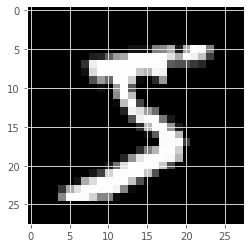

In [114]:
# read mnist data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# recombine train and test data
images = np.concatenate((train_images, test_images), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)
# print shapes
print('x_train shape:', images.shape)
print('y_train shape:', labels.shape)
# print a single image
print(f'image\'s shape: {images[0].shape}')
plt.imshow(images[0], cmap='gray')


In [115]:
# reshape image into a (X, 28, 28, 1) tensor
images = images.reshape(images.shape[0], 28, 28, 1).astype('float32')
images = (images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 70000 # number of images
BATCH_SIZE = 256 # number of images per batch


# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [116]:
# Build the generator
def build_generator():
    '''
        Build the generator model
        input: random noise from normal distribution
        output: generated image
    '''
    model = Sequential()
    # input layer, ouput shape (12544,)
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # reshape, output shape (7, 7, 256)
    model.add(layers.Reshape((7, 7, 256)))
    # conv2DTranspose or deconvolution1, output shape: (7, 7, 128)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # conv2DTranspose or deconvolution2, output shape: (14, 14, 64)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # conv2DTranspose or deconvolution3, output shape: (28, 28, 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.Activation('tanh'))

    # print model summary
    model.summary()

    return model

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_9 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 7, 7, 128)        

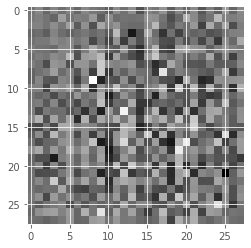

In [117]:
# create image from noise with untrained generator model
generator = build_generator()
# sampling noise from a normal distribution
noise = tf.random.normal([1, 100]) # mapping normal distribution to mnist image space
# print the noise
print(f"noise: {noise}")
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [118]:
# build the discriminator
def build_discriminator():
    '''
        Discriminator is a CNN-based image classifier.
        input: 28x28x1 image
        output: probability of the image being real or fake
    '''
    # cnn based classifier
    model = Sequential()
    # input layer, ouput shape (14, 14, 64)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # conv2D, output shape: (7, 7, 128)
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # flatten, output shape: (6272,)
    model.add(layers.Flatten())
    # dense, output shape: (1,) - real or fake
    model.add(layers.Dense(1))

    # print model summary
    model.summary()

    return model

In [119]:
# build the discriminator
discriminator = build_discriminator()
# classify the generated image
decision = discriminator(generated_image)
print(decision)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)             

In [120]:
# define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator loss
def discriminator_loss(real_output, fake_output):
    '''
        real_output: output of the discriminator for real images
        fake_output: output of the discriminator for fake images
        return: discriminator loss
    '''
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# generator loss
def generator_loss(fake_output):
    '''
        fake_output: output of the discriminator for fake images
        return: generator loss
    '''
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [121]:
# to save the checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [122]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# @tf.function # to speed up the training via compilation
def train_step(images):
    '''
      train_step function
      input: real images from the dataset
      output: loss of the generator and discriminator
    '''

    # generate noise from a normal distribution
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # recording the gradients
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # generate images from noise
      generated_images = generator(noise, training=True)
      # get the discriminator output for real images
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      # calculate the generator and discriminator loss
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      # print the losses
      # print(f"here generator's loss: {gen_loss}, discriminator's loss: {disc_loss}")

    # calculate the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # update the weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # convert from tensors to float
    val_gen_loss = gen_loss.numpy().astype(float)
    val_disc_loss = disc_loss.numpy().astype(float)

    # return the losses
    return val_gen_loss, val_disc_loss

In [123]:
def generate_and_save_images(model, epoch, test_input):
  '''
      generate and save images
      input: model, epoch, test input
      output: None
  '''
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('./gens/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open(f'./gens/image_at_epoch_{epoch_no:04d}.png')

In [124]:
def train(dataset, epochs):
  '''
      train function to train the generator and discriminator
      input: dataset (we want to generate synthetic data for), epochs (number of epochs)
      output: None
  '''
  # to store the losses
  gen_losses = []
  disc_losses = []

  for epoch in range(epochs):
    start = time.time()

    # to store the losses
    gen_batch_losses = []
    disc_batch_losses = []

    for image_batch in dataset:
      # print the batch shape
      # print(f"Batch shape: {image_batch.shape}") # (256, 28, 28, 1)
      gen_loss, disc_loss = train_step(image_batch)

      # add the batch losses
      gen_batch_losses.append(gen_loss)
      disc_batch_losses.append(disc_loss)
      
    # calculate the epoch losses
    gen_epoch_loss = np.mean(gen_batch_losses)
    disc_epoch_loss = np.mean(disc_batch_losses)
    # add the epoch losses
    gen_losses.append(gen_epoch_loss)
    disc_losses.append(disc_epoch_loss)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print the epoch time
    print (f'Epoch: {epoch + 1} took {time.time() - start} sec')
    # print the losses
    print(f"Generator's loss: {gen_epoch_loss}, Discriminator's loss: {disc_epoch_loss}")

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

  # print(f"generator's loss: {gen_losses}, discriminator's loss: {disc_losses}")

  plt.style.use('ggplot')
  plt.figure()

  plt.plot(range(epochs), gen_losses, label = 'Generator Loss')
  plt.plot(range(epochs), disc_losses, label = 'Discriminator Loss')

  plt.title('Losses')
  plt.xlabel('Epoch #')
  plt.ylabel('Loss')
  plt.legend()


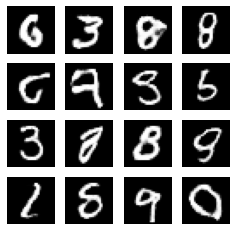

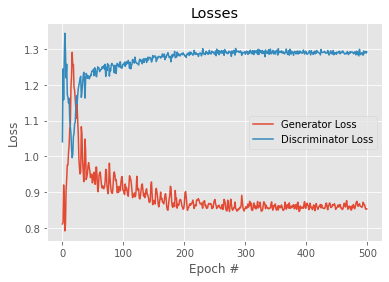

In [125]:
# train the models (important that generator and discriminator don't overpower each other)
EPOCHS = 500
train(train_dataset, EPOCHS)

In [126]:
# to restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

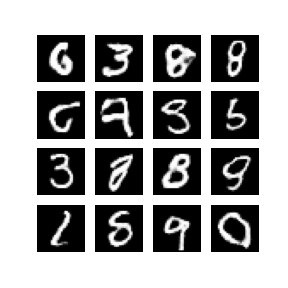

In [127]:
# display the last epoch image
display_image(EPOCHS)

In [128]:
# make a gif of the images
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  image = None
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

embed.embed_file(anim_file)


NameError: name 'filename' is not defined

Gan on CIFAR10

Images shape: (60000, 32, 32, 3)
Labels shape: (60000, 1)


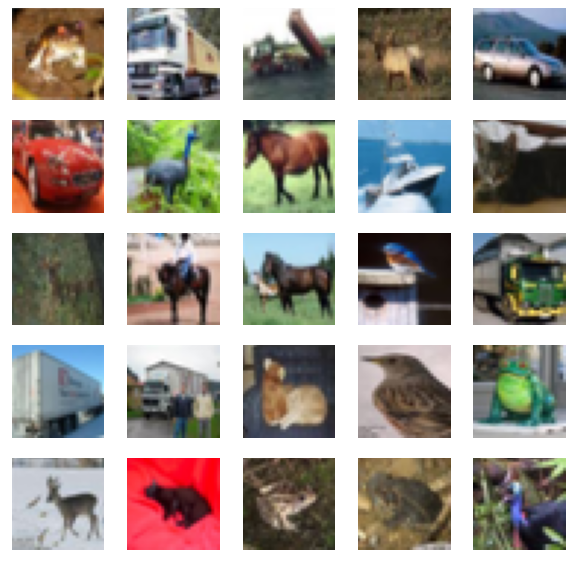

In [107]:
# load cifar 10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# recombine the train and test data 
images = np.concatenate((train_images, test_images))
labels = np.concatenate((train_labels, test_labels))
# print the shape of the images
print(f"Images shape: {images.shape}") 
print(f"Labels shape: {labels.shape}")

# plot some images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

In [110]:
# normalize the images to [-1, 1]
images = (images - 127.5) / 127.5
# print the shape of the images
print(f"Images shape: {images.shape}")
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# print values of the first image
print(f"First image: {images[0]}")

# create and shuffle the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(f"Train dataset shape: {train_dataset}")

Images shape: (60000, 32, 32, 3)
First image: [[[-1.00787619 -1.00787474 -1.00787426]
  [-1.00788391 -1.00788246 -1.00788294]
  [-1.00788053 -1.00788149 -1.00788391]
  ...
  [-1.00782842 -1.00784097 -1.00785255]
  [-1.00783132 -1.00784434 -1.00785544]
  [-1.00783325 -1.00784483 -1.00785496]]

 [[-1.00789693 -1.007895   -1.007895  ]
  [-1.00790465 -1.00790465 -1.00790465]
  [-1.00789597 -1.00790079 -1.00790465]
  ...
  [-1.00784531 -1.00786219 -1.00787812]
  [-1.00784724 -1.00786461 -1.00788053]
  [-1.00784579 -1.00786268 -1.00787715]]

 [[-1.00789259 -1.00789307 -1.00789452]
  [-1.00789693 -1.00790127 -1.00790465]
  [-1.00788101 -1.00789163 -1.00790079]
  ...
  [-1.00784772 -1.00786412 -1.00788053]
  [-1.00784676 -1.00786412 -1.00788053]
  [-1.00785206 -1.00786943 -1.00788439]]

 ...

 [[-1.0078043  -1.00782263 -1.00785834]
  [-1.00780768 -1.00783083 -1.00788825]
  [-1.00780912 -1.00782697 -1.00789211]
  ...
  [-1.00782746 -1.00784048 -1.00787088]
  [-1.00787763 -1.0078897  -1.00790127

In [111]:
# Build the generator
# TODO: modify to support cifar 10
def build_generator():
    '''
        Build the generator model
        input: random noise from normal distribution
        output: generated image
    '''
    model = Sequential()
    # input layer, ouput shape (12544,)
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # reshape, output shape (7, 7, 256)
    model.add(layers.Reshape((7, 7, 256)))
    # conv2DTranspose or deconvolution1, output shape: (7, 7, 128)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # conv2DTranspose or deconvolution2, output shape: (14, 14, 64)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # conv2DTranspose or deconvolution3, output shape: (32, 32, 3)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.Activation('tanh'))

    # print model summary
    model.summary()

    return model

In [ ]:
# create image from noise with untrained generator model
generator = build_generator()
# sampling noise from a normal distribution
noise = tf.random.normal([1, 100]) # mapping normal distribution to mnist image space
# print the noise
print(f"noise: {noise}")
generated_image = generator(noise, training=False)
# print the generated image
print(f"generated image: {generated_image}")
# plot the generated image
plt.imshow(generated_image[0, :, :, 0], cmap=plt.cm.binary)
plt.show()

In [ ]:
# build the discriminator
# TODO: modify to support cifar 10
def build_discriminator():
    '''
        Discriminator is a CNN-based image classifier.
        input: 28x28x1 image
        output: probability of the image being real or fake
    '''
    # cnn based classifier
    model = Sequential()
    # input layer, ouput shape (14, 14, 64)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # conv2D, output shape: (7, 7, 128)
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # flatten, output shape: (6272,)
    model.add(layers.Flatten())
    # dense, output shape: (1,) - real or fake
    model.add(layers.Dense(1))

    # print model summary
    model.summary()

    return model

In [ ]:
# build the discriminator
discriminator = build_discriminator()
# classify the generated image
decision = discriminator(generated_image)
print(decision)

In [ ]:
# define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator loss
def discriminator_loss(real_output, fake_output):
    '''
        real_output: output of the discriminator for real images
        fake_output: output of the discriminator for fake images
        return: discriminator loss
    '''
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# generator loss
def generator_loss(fake_output):
    '''
        fake_output: output of the discriminator for fake images
        return: generator loss
    '''
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
# to save the checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# @tf.function # to speed up the training via compilation
def train_step(images):
    '''
      train_step function
      input: real images from the dataset
      output: loss of the generator and discriminator
    '''

    # generate noise from a normal distribution
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # recording the gradients
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # generate images from noise
      generated_images = generator(noise, training=True)
      # get the discriminator output for real images
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      # calculate the generator and discriminator loss
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      # print the losses
      # print(f"here generator's loss: {gen_loss}, discriminator's loss: {disc_loss}")

    # calculate the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # update the weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # convert from tensors to float
    val_gen_loss = gen_loss.numpy().astype(float)
    val_disc_loss = disc_loss.numpy().astype(float)

    # return the losses
    return val_gen_loss, val_disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  '''
      generate and save images
      input: model, epoch, test input
      output: None
  '''
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap=plt.cm.binary)
      plt.axis('off')

  plt.savefig('./gens/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open(f'./gens/image_at_epoch_{epoch_no:04d}.png')

In [ ]:
def train(dataset, epochs):
  '''
      train function to train the generator and discriminator
      input: dataset (we want to generate synthetic data for), epochs (number of epochs)
      output: None
  '''
  # to store the losses
  gen_losses = []
  disc_losses = []

  for epoch in range(epochs):
    start = time.time()

    # to store the losses
    gen_batch_losses = []
    disc_batch_losses = []

    for image_batch in dataset:
      # print the batch shape
      # print(f"Batch shape: {image_batch.shape}") # (256, 28, 28, 1)
      gen_loss, disc_loss = train_step(image_batch)

      # add the batch losses
      gen_batch_losses.append(gen_loss)
      disc_batch_losses.append(disc_loss)
      
    # calculate the epoch losses
    gen_epoch_loss = np.mean(gen_batch_losses)
    disc_epoch_loss = np.mean(disc_batch_losses)
    # add the epoch losses
    gen_losses.append(gen_epoch_loss)
    disc_losses.append(disc_epoch_loss)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print the epoch time
    print (f'Epoch: {epoch + 1} took {time.time() - start} sec')
    # print the losses
    print(f"Generator's loss: {gen_epoch_loss}, Discriminator's loss: {disc_epoch_loss}")

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

  # print(f"generator's loss: {gen_losses}, discriminator's loss: {disc_losses}")

  plt.style.use('ggplot')
  plt.figure()

  plt.plot(range(epochs), gen_losses, label = 'Generator Loss')
  plt.plot(range(epochs), disc_losses, label = 'Discriminator Loss')

  plt.title('Losses')
  plt.xlabel('Epoch #')
  plt.ylabel('Loss')
  plt.legend()

In [ ]:
# train the models (important that generator and discriminator don't overpower each other)
EPOCHS = 2000
train(train_dataset, EPOCHS)

In [ ]:
# to restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# display the last epoch image
display_image(EPOCHS)

In [ ]:
# make a gif of the images
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  image = None
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

embed.embed_file(anim_file)